# Analyzing Airline Delay Data

In this notebook, we show some illustrative analysis of our flight delay dataset, exploring whether certain features in the dataset have any impact on flights being delayed.

**Note** the full flight delay dataset is very large (over 80GB uncompressed), so we are working with a smaller sample dataset. Hence any results may not be a true reflection of the results on the full dataset.

#### Import required modules

Import and configure the required modules.

In [1]:
!pip install seaborn > /dev/null 2>&1

In [2]:
# Define required imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', palette='deep')
# These set pandas max column and row display in the notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

### Read the data

We start by reading in the merged flight delay and weather data

In [3]:
flight_path = 'data/jfk_flight_weather_features.csv'
flight_data = pd.read_csv(flight_path, parse_dates=['flight_date'])
flight_data.head()

,flight_date,month,day_of_month,day_of_week,airline_id,airline_name,origin,dest,sched_dep_time,dep_time_bin,distance_bin,delayed,dep_delay,hour_key,date_key,DATE,visibility,weather_type_raw,wind_speed,wind_gust_speed,precip,rain,ice_pellets,mist,snow,drizzle,haze,fog,thunderstorm,smoke,unknown_precipitation
0,2015-03-17,3,17,2,20409,JetBlue,JFK,RSW,1525,1500-1559,5,0,-7,14,2015-03-17,2015-03-17 14:51:00,10.0,NaN,30,9,0.0,0,0,0,0,0,0,0,0,0,0
1,2016-05-25,5,25,3,20409,JetBlue,JFK,SJU,2119,2100-2159,7,0,0,20,2016-05-25,2016-05-25 20:51:00,10.0,NaN,11,0,0.0,0,0,0,0,0,0,0,0,0,0
2,2017-07-26,7,26,3,19805,American Airlines,JFK,SFO,700,0700-0759,11,0,-3,6,2017-07-26,2017-07-26 06:51:00,10.0,NaN,7,0,0.0,0,0,0,0,0,0,0,0,0,0
3,2010-12-11,12,11,6,20409,JetBlue,JFK,LAS,1900,1900-1959,9,0,-5,18,2010-12-11,2010-12-11 18:51:00,10.0,NaN,3,0,0.0,0,0,0,0,0,0,0,0,0,0
4,2012-08-11,8,11,6,20398,Envoy Air,JFK,IND,1510,1500-1559,3,0,-2,14,2012-08-11,2012-08-11 14:51:00,10.0,NaN,18,0,0.0,0,0,0,0,0,0,0,0,0,0


### Analyze the data

Now we will analyze the data to see if we can gain insight into flight delays.

Let's start by looking at the overall proportion of flights that are delayed.

On-time: 79.16%
Delayed: 20.84%


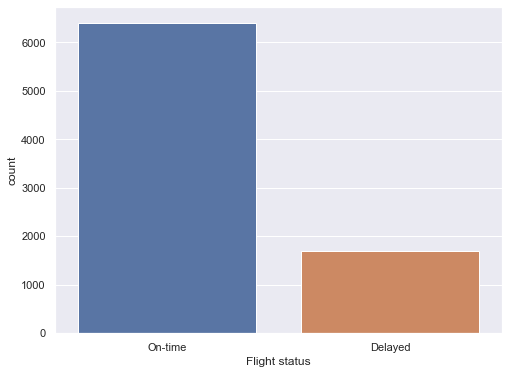

In [4]:
vc = flight_data['delayed'].value_counts()
perc = vc / sum(vc)
print('On-time: {:.2f}%'.format(perc[0] * 100))
print('Delayed: {:.2f}%'.format(perc[1] * 100))
plt.figure(figsize=(8, 6))
chart = sns.countplot(data=flight_data, x='delayed')
chart.set_xticklabels(['On-time', 'Delayed'])
chart.set_xlabel('Flight status')
plt.show()

We see 80% of flights are on-time. Still, a fairly high proportion of 20% of flights are delayed - recall delayed here means more than 15 minutes late!

#### Analyze and visualize flight delay durations
Next, we will plot the flight delay (in minutes) over time.

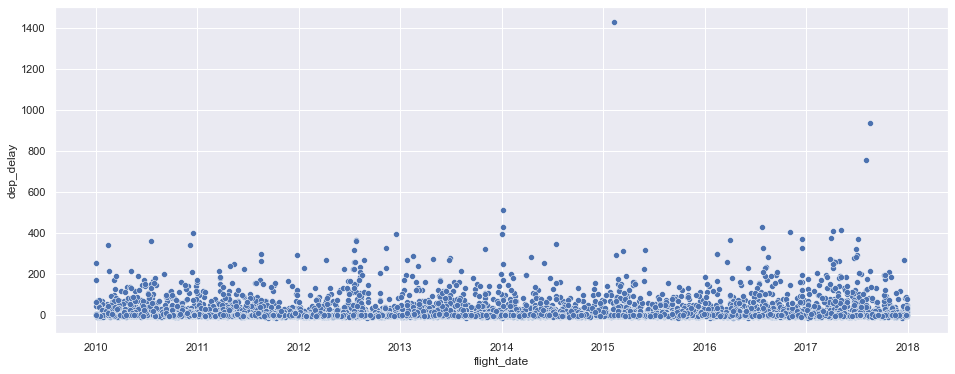

In [5]:
plt.figure(figsize=(16, 6))
chart = sns.scatterplot(x='flight_date', y='dep_delay', data=flight_data)
plt.show()

There doesn't appear to be any obvious relationship. It is worth noting that most flight delay lengths are very low (clustered around zero), with a relatively small number of very large values (i.e. _outliers_). This may tend to skew analysis based on, for example, analyzing the _average_ flight delay duration. This also consistent with our proportion analysis above.

Let's look at whether flight delays are impacted by the day of the week:

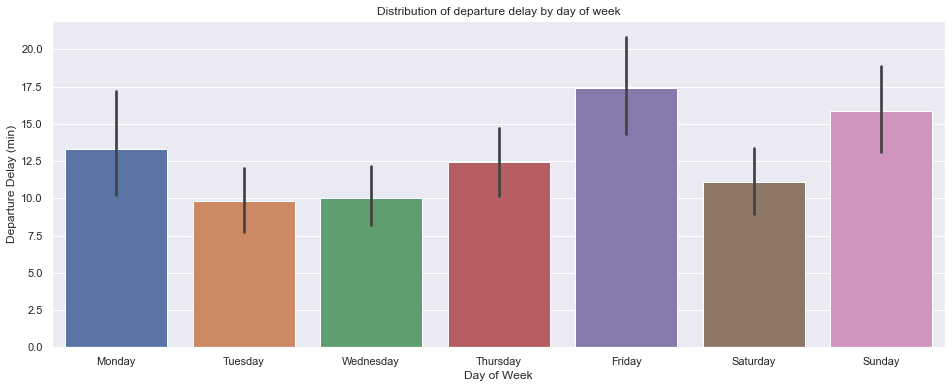

In [6]:
plt.figure(figsize=(16, 6))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
chart = sns.barplot(x='day_of_week', y='dep_delay', data=flight_data)
chart.set_xticklabels(days)
chart.set_xlabel('Day of Week')
chart.set_ylabel('Departure Delay (min)')
chart.set_title('Distribution of departure delay by day of week')
plt.show()

This chart shows the average and confidence interval (standard deviation) for flight delays, grouped by day of week. It appears from the chart that Monday, Friday and Sunday are the worst days to fly, with respect to the average flight delay. Perhaps this is due to a larger volume of flights on those days? We can in fact check this by plotting the total number of flights per weekday in the dataset.

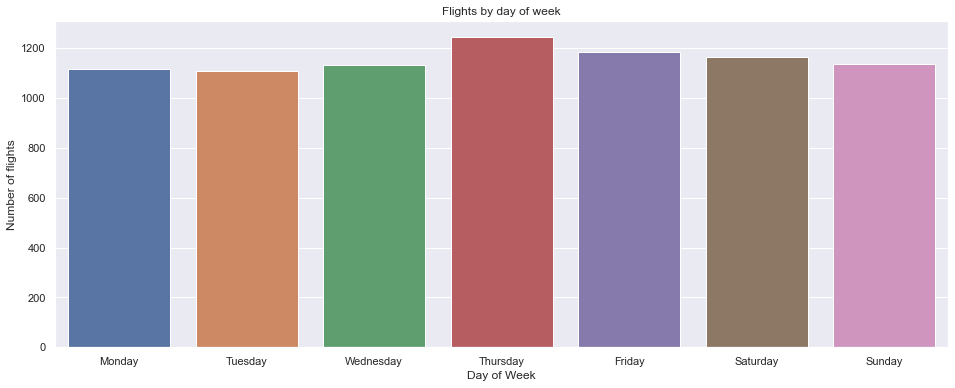

In [7]:
plt.figure(figsize=(16, 6))
chart = sns.countplot(x='day_of_week', data=flight_data)
chart.set_xticklabels(days)
chart.set_xlabel('Day of Week')
chart.set_ylabel('Number of flights')
chart.set_title('Flights by day of week')
plt.show()

There doesn't appear to be an obvious correlation between volume of flights and which days experience larger flight delays.

**Note** however, that we are not taking into account volumes of arriving flights in this analysis, which may have an impact!

Recall that the flight delay data appeared to have many outlier values. This means the distribution of flight delays is very skewed. We should take a look at a view that takes this into account:

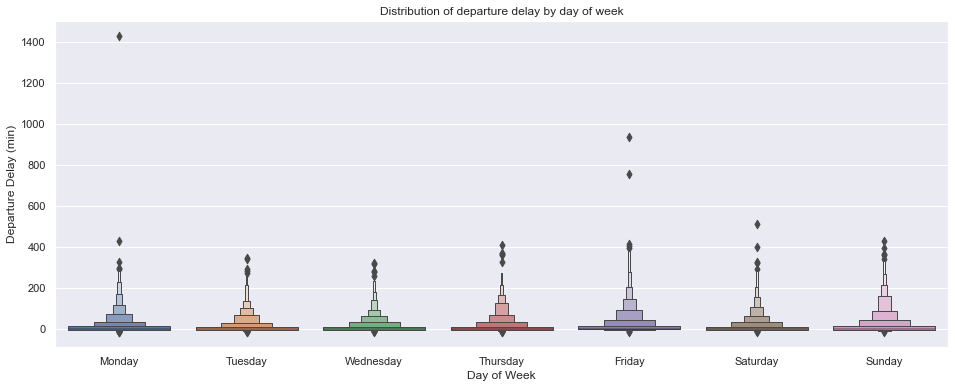

In [8]:
plt.figure(figsize=(16, 6))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
chart = sns.boxenplot(x='day_of_week', y='dep_delay', data=flight_data)
chart.set_xticklabels(days)
chart.set_xlabel('Day of Week')
chart.set_ylabel('Departure Delay (min)')
chart.set_title('Distribution of departure delay by day of week')
plt.show()

The above chart shows a more detailed distribution of the flight delay for each weekday. This shows that Monday and Friday definitey have some extremely large outlier values that play a role in their higher average flight delays.

We can also see that Friday and Sunday have "wider" and "higher" blocks at moderately higher flight delay levels. This contributes to the higher average flight delays and tells us that outliers alone are not fully to blame for the higher average delays on these days.

It is usually wise to dig a bit deeper when visualizing skewed or imbalanced datasets. 

#### Analyze and visualize flight delay proportions for flight features
Next, we will analyze the proportion of flights that are delayed, for given sets of features in our dataset related to the **flight** itself. Since we wish to build a classifier, this analysis can help us to understand which features may be indicative of greater probability of a flight delay and which features have little impact.

First, we will define a convenience function to create our stacked proportion charts:

In [9]:
def plot_stacked_by_col(col, x_label, rotation=0, horizontalalignment='center', xticks=None):
    grouped = flight_data['delayed'].groupby(flight_data[col]).value_counts()
    g = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

    chart = g.unstack().plot(kind='bar', stacked=True, figsize=(16, 6))
    chart.set_xticklabels(
        xticks if xticks else chart.get_xticklabels(),
        rotation=rotation, 
        horizontalalignment=horizontalalignment,
        fontweight='light',
        fontsize='medium'
    )
    chart.set_xlabel(x_label)
    chart.set_ylabel('Proportion delayed')
    chart.set_title('Proportion of flights delayed, by {}'.format(x_label))
    plt.show()

Let's start by analyzing proportion of flights delayed by weekday, continuing the theme of our analsis above.

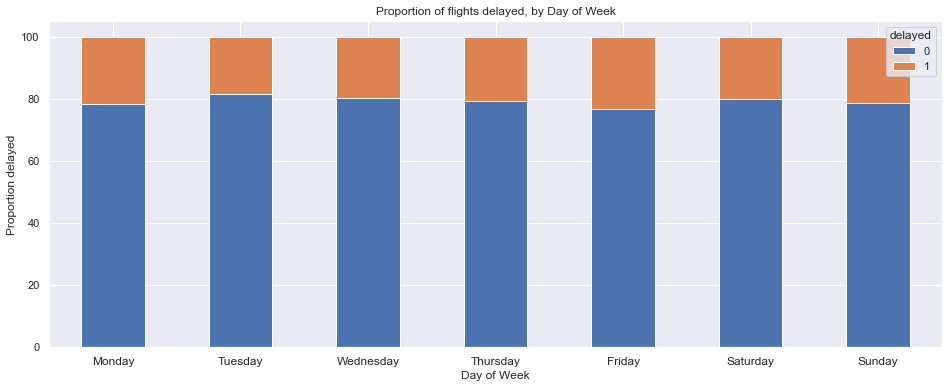

In [10]:
plot_stacked_by_col('day_of_week', 'Day of Week', xticks=days)

This chart roughly matches the delay duration charts above, with Monday, Friday and Sunday having the highest proportion of delayed flights, while Tuesday and Wednesday are the "best" days. This indicates that day of the week may be at least somewhat useful for predicting flight delays.

Next, we plot the proportions by departure time (where departure times are grouped into hourly buckets, with the exception of a larger bucket for "early morning flights").

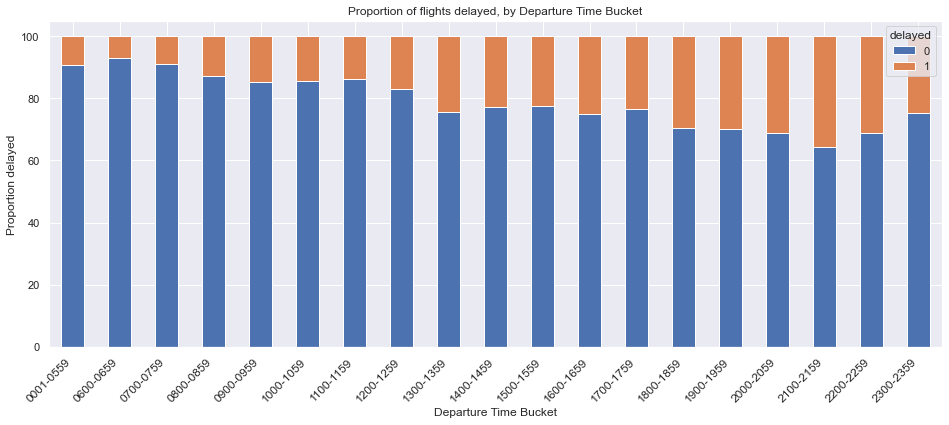

In [11]:
plot_stacked_by_col('dep_time_bin', 'Departure Time Bucket', rotation=45, horizontalalignment='right')

It seems clear that flights later in the day have a generally higher chance of being delayed, relative to flights in the morning (and especially early morning). Perhaps this is related to flight volumes - are flight volumes lower in the early morning?

Again, we can check this by plotting the number of flights per departure time bucket.

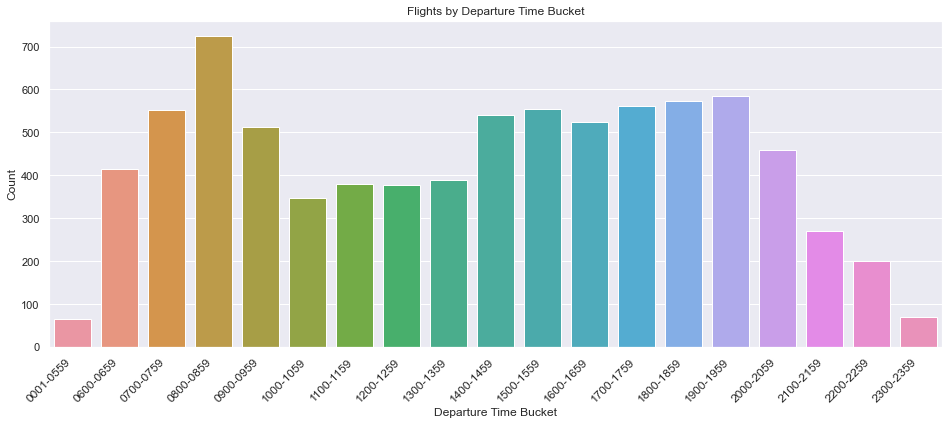

In [12]:
plt.figure(figsize=(16, 6))
chart = sns.countplot(
    x='dep_time_bin',
    data=flight_data,
    order=flight_data.groupby(flight_data['dep_time_bin']).groups.keys())
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'
)
chart.set_xlabel('Departure Time Bucket')
chart.set_ylabel('Count')
chart.set_title('Flights by Departure Time Bucket')
plt.show()

While there are definitely relatively fewer very early flights, there are more flights in the early morning, and these are less likely to be delayed than afternoon flights, depsite flight volumes being similar between the two groups. Also, there are relatively lower volumes of late night flights, while these are relatively more likely to be delayed. So, flight volumes don't seem to play much of a role.

**Note** however, that we are not taking into account volumes of arriving flights in this analysis, which may have an impact!

Next, let's see if a particular airline's flights are more likely to be delayed.

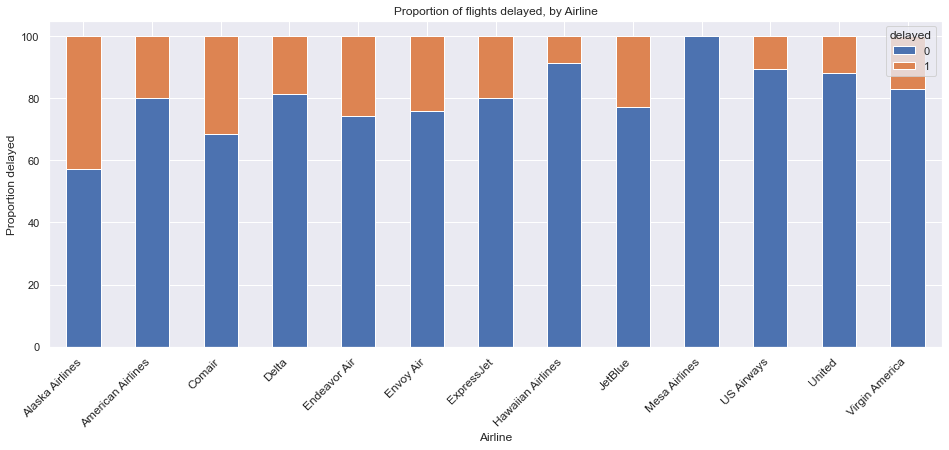

In [13]:
plot_stacked_by_col('airline_name', 'Airline', rotation=45, horizontalalignment='right')

It seems like the airline does have some impact on delay proportion (note volumes for some smaller airlines may be quite low due to sampling). How about flight destination?

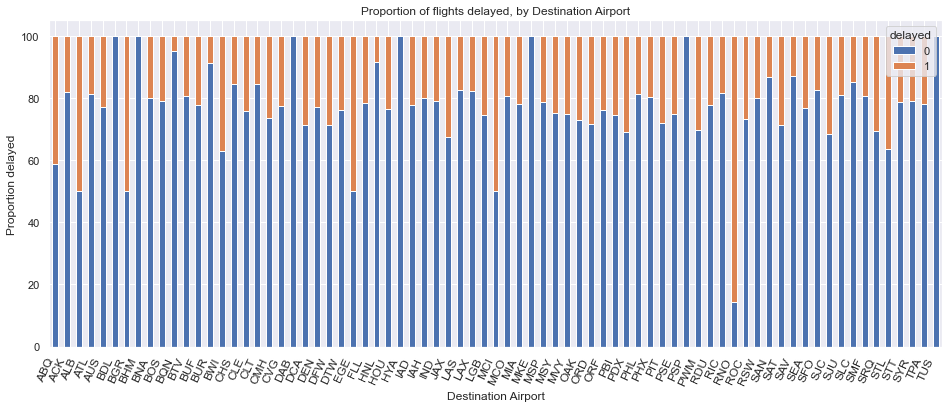

In [14]:
plot_stacked_by_col('dest', 'Destination Airport', rotation=65, horizontalalignment='right')

Again, it appears there is a relationship between proportion of flights delayed and the flight destination (the same caveats with respect to sampled data as mentioned above, would apply here).

Finally, what about flight distance?

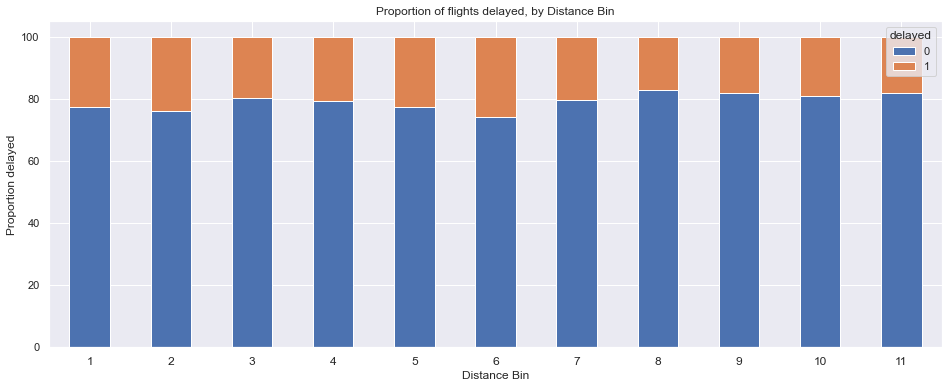

In [15]:
plot_stacked_by_col('distance_bin', 'Distance Bin', rotation=0, horizontalalignment='center')

It seems like there may be some relationship, though it's not particlarly clear - shorter flights and longer flights tend to have roughly similar proportions.

#### Analyze and visualize flight delay proportions for weather features
Now, we will analyze the proportion of flights that are delayed, for given sets of **weather** features in our dataset.

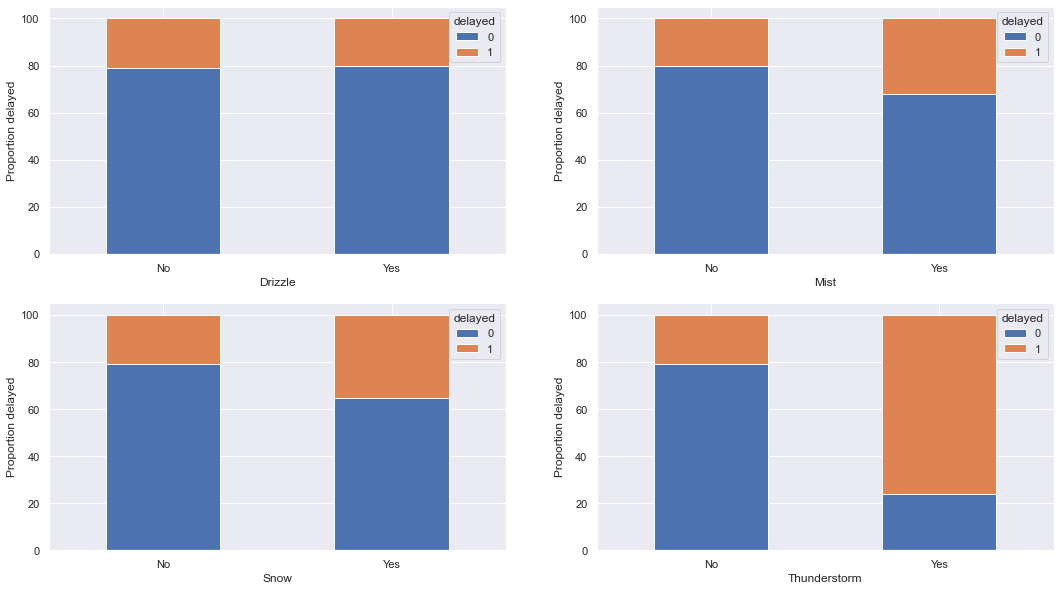

In [16]:
# create sub-plots for a few weather conditions

ax = plt.subplot(221)
grouped = flight_data['delayed'].groupby(flight_data['drizzle']).value_counts()
g = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
chart = g.unstack().plot(kind='bar', stacked=True, figsize=(18, 10), ax=ax)
chart.set_xticklabels(['No', 'Yes'], rotation=0)
chart.set_xlabel('Drizzle')
chart.set_ylabel('Proportion delayed')

ax = plt.subplot(222)
grouped = flight_data['delayed'].groupby(flight_data['mist']).value_counts()
g = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
chart = g.unstack().plot(kind='bar', stacked=True, figsize=(18, 10), ax=ax)
chart.set_xticklabels(['No', 'Yes'], rotation=0)
chart.set_xlabel('Mist')
chart.set_ylabel('Proportion delayed')

ax = plt.subplot(223)
grouped = flight_data['delayed'].groupby(flight_data['snow']).value_counts()
g = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
chart = g.unstack().plot(kind='bar', stacked=True, figsize=(18, 10), ax=ax)
chart.set_xticklabels(['No', 'Yes'], rotation=0)
chart.set_xlabel('Snow')
chart.set_ylabel('Proportion delayed')

ax = plt.subplot(224)
grouped = flight_data['delayed'].groupby(flight_data['thunderstorm']).value_counts()
g = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
chart = g.unstack().plot(kind='bar', stacked=True, figsize=(18, 10), ax=ax)
chart.set_xticklabels(['No', 'Yes'], rotation=0)
chart.set_xlabel('Thunderstorm')
chart.set_ylabel('Proportion delayed')

plt.show()

From these charts, it appears that the presence of "drizzle" does not impact on whether a flight is likely to be delayed - as we might expect. However, if there is snow or a thunderstorm, for example, it appears flight delays are much more likely.

We have touched on only a little of the analysis of weather features that could be performed. For example, one could explore more of the weather conditions similarly to the cell above; or investigate the potential relationship between features such as `visibility`, `wind_speed` and `precip` to both proportions of flights delayed as well as duration of flight delays. 

<a id="authors"></a> 
### Authors

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.